<a href="https://colab.research.google.com/github/DavidMartinezGonzalez/TutorialOnNeuralVocoders/blob/main/chapter_6_AR_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome


This is the hands-on session for ICASSP 2022 short course **Inclusive Neural Speech Synthesis**, **LECTURE 1, neural vocoder**.

Click [HERE](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7?usp=sharing) to go back to the entry point of this hands-on session.


## About this notebook

In this notebook, we will cover the autoregressive [WaveNet](https://arxiv.org/abs/1609.03499).

We will cover:
1. Pytorch module definition with example usages (Sec.1)
2. Demonstration of speech generation using a pre-trained model (Sec.2)

Original WaveNet takes linguistic features as input. Here, we use acoustic features as input.

## preparation

In [1]:
!echo "Download external zip "
!wget --quiet --show-progress -O iNSS.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AABxjrZhQBRM1YEekjWs8Pl2a/iNSS
!echo "Unzip files"
!unzip -q -o iNSS.zip -x / -d /content
!if [ -d "/content/data_models" ]; then echo "Done"; else echo "Please contact with the author"; fi

Download external zip 
iNSS.zip            100%[===================>] 402.88M  16.7MB/s    in 29s     
Unzip files
Done


In [2]:
# for convenience, define a path to the folder on Google Colab runtime
g_workpath = '/content'

In [3]:
# load packages
from __future__ import absolute_import
from __future__ import print_function

import os
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# basic nn blocks
# these include the conv1D wrapper and other basic
# blocks discussed in previous chapters
import sandbox.block_nn as nii_nn
import sandbox.block_dist as nii_dist
import sandbox.util_dsp as nii_dsp

# misc functions for this demonstration book
import IPython.display
import tool_lib
from plot_tools import plot_API
from plot_tools import plot_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts']))

matplotlib.rc usetex is disabled


# Sec.1 Pytorch Module Definition

Implementations vary. Here we divide the model into four parts:
* **waveform embedding**: convert discrete waveform values to embedding vectors
* **condition module**: process input features and do upsampling
* **wavenet core**: dilated conv layers, gated activation ...
* **output module**: computes the categorical distribution for discrete waveform values



```sh
Model during training

  -------------------------------------------------------------------------------  Wave
  |                                                                          -------|-------
  |                                                                          |      v      |
  |                                                                          |   Loss ()   |
  |                                                                          |      ^      |
  |                     ===================================================  |      | dist.|
  |                     | WaveNet core                                    |  |      |      |
  |                     |       -------------> + ---------------> + ------|->|output module|
  |                     |       |              ^                  ^       |  ---------------
  v                     |       |              |                  |       |  
           -----------  |  -----------    -----------        -----------  |
|z^-1| --> |embedding| --> |WNBlock 1| -> |WNBlock 2| -> ... |WNBlock N|  |
           -----------  |  -----------    -----------        -----------  |
                        |       ^              ^                  ^       |
                        ========|==============|==================|========
                                |              |                  |
                                -----------------------------------
                    -----------                |
input_features -->  |condition| -> upsampled_features
                    -----------
```

Note:
1. $z^{-1}$ denotes delaying the feedback wave by 1 time step
2. WNBlock: WaveNet block with a dilated convolution layer, gated activation, and so on. We will explain it in more detail later.

We will walk through each module.

## Sec.1.1 Waveform Presentation & Embedding


Original WaveNet treats waveform values as discrete symbols:
```sh
waveform -> u-law companding -> quantization -> discrete values -> training target
```

It also possible to include pre-emphasis before $\mu$-law companding
```sh
waveform -> pre-emphasis -> u-law companding -> quantization -> discrete values -> training target
```

In this notebook we include the pre-emphasis.

Details of pre-emphasis and $\mu$-law companding are covered in `chapter_2`.




In [4]:
# Let's load a waveform
wavfile_path = os.path.join(g_workpath, "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav")
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)

# convert it to tensor
# following the convention defined in chapter 1, we reshape it to (batch, length, 1)
wave_data_tensor = torch.tensor(wave_data, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

### Pre-emphasis, companding, and quantization

We will use Pytorch to implement the three steps.

In [5]:
# Pre-emphasis H(z) = 1 - 0.97z^{-1}
#
wave_data_preemph_tensor = torch.zeros_like(wave_data_tensor)
with torch.no_grad():
    wave_data_preemph_tensor[:, 0, :] = wave_data_tensor[:, 0, :]
    wave_data_preemph_tensor[:, 1:, :] = wave_data_tensor[:, 1:, :] - 0.97 * wave_data_tensor[:, 0:-1, :]

In [6]:
# mu-law companding and quantization
#  we use the API in /content/sandbox/util_dsp.py
#  it does both companding and quantization
#
#  this API is Pytorch-tensor based, its numpy version has been
#  explained in chapter 2

# number of bits to quantize the waveform, there we use 10 bits
num_bits = 10
# i.e., the number of discrete waveform classes will be 2^10
num_classes = 2 ** num_bits

with torch.no_grad():
    # do mu-law compandign and quantization
    wave_data_quanized = nii_dsp.mulaw_encode(wave_data_preemph_tensor, num_classes)

(<Figure size 1000x500 with 3 Axes>,
 <Axes: title={'center': 'mu-law companded and quantized waveform'}, xlabel='waveform time index', ylabel='Symbol IDs'>)

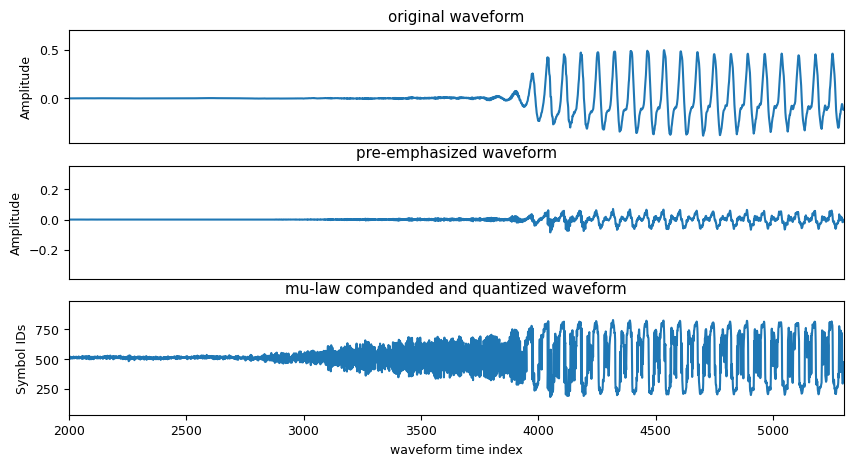

In [7]:
# Plot and check
#  We use a plot_API to plot the figures, the details are in /content/plot_tools
plot_API.plot_API(
    [wave_data,
     wave_data_preemph_tensor[0, :, 0].numpy(),
     wave_data_quanized[0, :, 0].numpy()],
    plot_lib.plot_signal,
    'v',
    {'xlim': (2000, 5300),
     'sub': [{'title': 'original waveform', 'ylabel': 'Amplitude'},
             {'title': 'pre-emphasized waveform', 'ylabel': 'Amplitude'},
             {'title': 'mu-law companded and quantized waveform', 'ylabel': 'Symbol IDs'}],
     'xlabel': 'waveform time index', 'sharex': True})

The pre-emphasized waveform looks different from the original waveform. In the frequency domain, the difference is mainly on the energy distribution in low and high frequency bands.

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'pre-emphasized waveform'}, xlabel='Frame index', ylabel='Frequency bins'>)

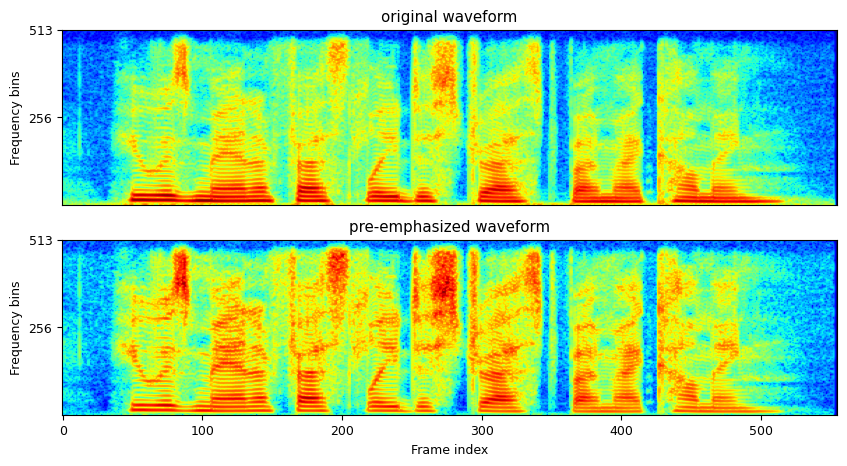

In [8]:
plot_API.plot_API(
    [wave_data, wave_data_preemph_tensor[0, :, 0].numpy()],
    plot_lib.plot_spec,
    'v',
    {'sub': [{'title': 'original waveform'},
             {'title': 'pre-emphasized waveform'}],
     'xlabel': 'Frame index', 'sharex': True})

### Waveform Embedding


The quantized waveform is used at two places during model training:
* as the training target
* as the feedback input to WaveNet

For the 1st usage, we will cover it later.

For the 2nd usage, it is common to convert the quantized waveform symbols into a continuous-valued vector, i.e., $\mathbb{Z}\rightarrow \mathbb{R}^{D}$.

Let's call it embedding -- the same idea as embedding vectors for natural language processing tasks.

Some implementations don't explicitly show the embedding process but they implicitly do that.

We simply use the Pytorch embedding API (https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

```python
                          -----------   
wave discrete symbols --> |embedding| -->  embedding vectors
                          -----------  
```


In [9]:
# dimension of embedding
embedding_dim = 64

# claim the embedding layer
l_wav_emb = torch_nn.Embedding(num_classes, embedding_dim)

# embedding
#.  note that wave_data_quanized has shape (batch, length, 1)
#   but Embedding expects (batch, length)
with torch.no_grad():
    waveform_embedding = l_wav_emb(wave_data_quanized.squeeze(-1))

In [10]:
#
print("Embedding vectors are in shape: %s" % (str(waveform_embedding.shape)))
print(" batch size {:d}, sequence length {:d}, dimension per time step {:d} ".format(
        *waveform_embedding.shape))

# check the embeddings for a few time steps
time_idices = [100, 200]
for time_idx in time_idices:
    print("\nFor waveform at time step {:d}:".format(time_idx))
    print("Quantized waveform value: {:d}".format(wave_data_quanized[0, time_idx, :].item()))
    print("Corresponding emebedding vector:\n", waveform_embedding[0, time_idx, :])

Embedding vectors are in shape: torch.Size([1, 44241, 64])
 batch size 1, sequence length 44241, dimension per time step 64 

For waveform at time step 100:
Quantized waveform value: 527
Corresponding emebedding vector:
 tensor([ 0.4905, -0.2854, -0.2551,  1.0784,  0.3423, -0.3828, -0.4212, -0.4881,
         0.0664, -0.6199, -0.4469,  1.4750,  1.6786, -1.1600, -0.3213,  0.8818,
        -0.8411,  0.4014,  0.5306,  1.7857,  1.3145,  2.0974,  0.5099,  0.3035,
         0.3228,  0.4502,  0.4833,  0.0656,  1.8498, -0.7858,  0.4624,  0.4411,
         0.6985, -1.0329,  0.7708, -0.3157, -1.2411,  0.4941,  0.1848,  0.9863,
        -0.0660,  0.9028,  0.0464,  0.4367, -1.0429, -1.5380,  0.3174, -1.7534,
        -0.6535, -0.6752, -0.1633, -0.6171,  2.0217,  0.1646, -0.1157, -0.2007,
         0.4698, -0.1103,  0.7956,  0.6857, -0.1518,  0.3402, -0.8623, -0.5797])

For waveform at time step 200:
Quantized waveform value: 536
Corresponding emebedding vector:
 tensor([-8.8682e-01, -2.2226e-02, -1.2297e

**Note**

Rather than discrete symbols, waveform values can be modeled as continuous-valued numbers. Then the model uses Mixture-of-logistic (Oord 2018) or Gaussian (Ping 2019).

I personally found the Gaussian distribution is reasonablly good (Wang 2019), but the Gaussian variance needs to be handled carefully. See page 44-51 of my slide. (Please search `Neural waveform models for text-to-speech synthesis` on this [webpage](http://tonywangx.github.io/slide.html).)

* van den Oord, A. et al. Parallel WaveNet: Fast high-fidelity speech synthesis. in Proc. ICML 3918–3926 (2018).
* Ping, W., Peng, K. & Chen, J. ClariNet: Parallel wave generation in end-to-end text-to-speech. Proc. ICLR (2019).
* Wang, X., Takaki, S. & Yamagishi, J. Neural Source-filter-based Waveform Model for Statistical Parametric Speech Synthesis. in Proc. ICASSP 5916–5920 (2019)

## Sec.1.2 Condition Module

Let's switch the focus to the condition features.

The condition module transforms and upsamples the input acoustic features (e.g., Mel-spec).

The condition module can be designed in numerous ways. Here we use Bi-LSTM and simple duplication-based up-sampling.

```python
.
         ============================================
         | condition module                         |
         |  ---------    --------    -------------  |
c_1:M -> |  |Bi-LSTM| -> |conv1d| -> | Upsampling|  |   -> c_{1:N}
         |  ---------    --------    -------------  |
         ============================================         
```

* $\boldsymbol{c}_{1:M}$ denotes the input feature sequence with $M$ frames
* $\tilde{\boldsymbol{c}}_{1:N}$ denotes the upsampled feature sequence of $N$.

The $N$ should be **equal to the length of the target waveform**, and $N = M \times \text{upsampling-rate}$.

The upsampling rate is decided by the sampling rate of the waveform and the configuration of acoustic features.

For 16kHz waveform and input features extracted with frame-shift 5ms, the upsampling rate is $80 = 16 * 5$.

The implementation of the condition module is straightforward:

In [11]:
class CondModule(torch_nn.Module):
    """ Conditiona module: upsample and transform input features
    """
    def __init__(self, input_dim, output_dim, up_sample, \
                 blstm_s = 64, cnn_kernel_s = 3):
        """ CondModule(input_dim, output_dim, up_sample,
        blstm_s=64, cnn_kernel_s=3)

        Args
        ----
          input_dim: int, input tensor should be (batchsize, len1, input_dim)
          output_dim: int, output tensor will be (batchsize, len2, output_dim)
          up_sample: int, up-sampling rate, len2 = len1 * up_sample

          blstm_s: int, layer size of the Bi-LSTM layer
          cnn_kernel_s: int, kernel size of the conv1d
        """
        super(CondModule, self).__init__()

        # configurations
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.up_sample = up_sample
        self.blstm_s = blstm_s
        self.cnn_kernel_s = cnn_kernel_s

        # layers
        self.l_blstm = nii_nn.BLSTMLayer(input_dim, self.blstm_s)
        self.l_conv1d = nii_nn.Conv1dKeepLength(
            self.blstm_s, output_dim, 1, self.cnn_kernel_s)
        self.l_upsamp = nii_nn.UpSampleLayer(
            self.output_dim, self.up_sample, True)

    def forward(self, feature):
        """ transformed_feat = forward(input_feature)

        input
        -----
          feature: (batchsize, length, input_dim)

        output
        ------
          transformed_feat: tensor (batchsize, length*up_sample, out_dim)
        """
        return self.l_upsamp(self.l_conv1d(self.l_blstm(feature)))


* `nii_nn.BLSTMLayer` is the Bi-LSTM layer covered in `chapter 1`;
* `nii_nn.Conv1dKeepLength` is the conv1d layered introduced in `chpater 1`;
* `nii_nn.UpsampleLayer` is the up-sampling layer with a optional moving-average filter;

These APIs are available in `/content/sandbox/block_nn.py`


Let's try some toy examples.

In [12]:
# Create an input feature matrix of size (batchsize, frame_length, feature_dim)
frame_length = 30
feature_dim = 16
batchsize = 2
input_feature = torch.rand(batchsize, frame_length, feature_dim)

# Initialzie a Condition module, which up-samples input feature for 80 times
# (80 = 16 kHz * 5 ms frame-shift)
output_dim = 16
up_sample = 80
m_cond = CondModule(feature_dim, output_dim, up_sample)

with torch.no_grad():
    feature_upsampled = m_cond(input_feature)


In [13]:
# Do a simple check
print("Input feature shape: {:s}".format(str(input_feature.shape)))
print("Output feature shape: {:s}".format(str(feature_upsampled.shape)))
print("Output feature batch size {:d}, length {:d}, dim {:d} ".format(
    *feature_upsampled.shape))

Input feature shape: torch.Size([2, 30, 16])
Output feature shape: torch.Size([2, 2400, 16])
Output feature batch size 2, length 2400, dim 16 


## Sec.1.4 WaveNet Core Blocks

WaveNet has many hidden layers.

To facilitate the explanation, we organize the hidden layers into multiple core blocks (`WNBlock`).

```sh
      ===================================================  
      | WaveNet backbone                                |  
      |       -------------> + ---------------> + ------|-> output_feature
      |       |              ^                  ^       |  
      |       |              |                  |       |  
      |  -----------    -----------        -----------  |
Input--> |WNBlock 1| -> |WNBlock 2| -> ... |WNBlock N|  |
      |  -----------    -----------        -----------  |
      |       ^              ^                  ^       |
      ========|==============|==================|========
              |              |                  |
              ---------------|-------------------
             upsampled condition features
```

Note that we will show example usages of these modules in the training phase. The generation phase will be discussed later.

### Implementation of a Single block

```sh
          3
          ^         
          |         
     -----------    
1 -> |WNBlock k| -> 4
     -----------    
          ^
          |
          2
```    

Each block receives as input:
1. output of previous block or waveform embedding (if this is the 1st block)
2. condition features

Its output:

3. features used by output module
4. features used by the next block

The 3 and 4 are usually referred to as skip-channel and residual channel respectively. (See Fig.4, van den Oord, A. et al. WaveNet: A Generative Model for Raw Audio. CoRR abs/1609.0, (2016))






Implementation of WNBlock varies in different implementations.

**A common way** (see `/content/sandbox/block_wavenet.py WaveNetBlock_V2`):
```sh
                                                         3            
                                                         ^                     
     ====================================================|================
     |                                                   |               |
     | |-------------------------------------------------|---------      |
     | |                                                 |        |      |
     | |                                                 FC       |      |
     | |   ----------------               |-> tanh ->|   |        v      |
1 -> | ->  |dilated-conv1d| -> + -> split-|          x ---> FC -> + ------> 4
     |     ----------------    ^          |-> sig  ->|                   |
     |                         |                                         |
     |     ----------------    |                                         |
     |     |      FC      | ---|                                         |
     |     ----------------                                              |
     |            ^                                                      |
     =============|=======================================================
                  |
                  2

```

**Another way** (I used for historical reason in `/content/sandbox/block_wavenet.py WaveNetBlock`):
```sh
                                                                     3
                                                                     ^     
     ================================================================|====
     |                                                               |   |
     | |----------------------------------------------------------   |   |
     | |                                                         |   FC  |
     | |                                                         |   |   |
     | |   ----------------               |-> tanh ->|           v   |   |
1 -> | ->  |dilated-conv1d| -> + -> split-|          x --> FC -> + -------> 4
     |     ----------------    ^          |-> sig  ->|                   |
     |                         |                                         |
     |     ----------------    |                                         |
     |     |      FC      | ---|                                         |
     |     ----------------                                              |
     |            ^                                                      |
     =============|=======================================================
                  |
                  2
```

The difference is that the skip-channel feature (3) is transformed from residual channel feature (4).


In both cases, **a key configuration parameter is the dilation size** of the dilated 1d convolution.

Below is the definition for the 2nd way.

In [14]:
# Copy the module definition from sandbox.block_wavenet.WaveNetBlock

class WaveNetBlock(torch_nn.Module):
    """ WaveNet block based on dilated-1D, gated-activation, and skip-connect.
    Based on http://tonywangx.github.io/slide.html#misc CURRENNT WaveNet,
    page 19-31.
    """
    def __init__(self, input_dim, skip_ch_dim, gated_act_dim, cond_dim,
                 dilation_size, cnn_kernel_size=2, causal=True):
        """ WaveNetBlock(input_dim, skip_ch_dim, gated_act_dim, cond_dim,
        dilation_size, cnn_kernel_size = 2)

        Args
        ----
          input_dim: int, input tensor should be (batch-size, length, input_dim)
                     this is the dimension of residual channel
          skip_ch_dim: int, tensors to be send to output blocks is in shape
                            (batch-size, length, skip_ch_dim)
          gated_act_dim: int, tensors given by tanh(.) * sig(.) is in shape
                            (batch-size, length, gated_act_dim)
          cond_dim: int, conditional feature (batchsize, length, cond_dim)

          dilation_size: int, dilation size of the conv
          cnn_kernel_size: int, kernel size of dilated conv1d (default, 2)
          causal: bool, whether this block is used in AR model (default, True)

        Note that causal==False will raise error if step-by-step generation
        is conducted by inference(input_feat, cond_feat, step_idx) with
        step_idx != None.
        For causal==False, always use inference(input_feat, cond_feat, None)
        """
        super(WaveNetBlock, self).__init__()

        #####
        # configurations
        #####
        # input tensor: (batchsize, length, self.input_dim)
        self.input_dim = input_dim
        # tensor sent to next WaveNetBlock, same shape as input
        self.res_ch_dim = input_dim
        #
        self.skip_ch_dim = skip_ch_dim
        self.gated_act_dim = gated_act_dim
        self.cond_dim = cond_dim
        self.dilation_size = dilation_size
        self.conv_kernel_s = cnn_kernel_size

        ######
        # layers
        ######
        # dilated convolution
        self.l_conv1d = nii_nn.Conv1dForARModel(
            self.input_dim, self.gated_act_dim * 2, self.dilation_size,
            self.conv_kernel_s, tanh=False)

        # condition feature transform
        self.l_cond_trans = torch_nn.Sequential(
            torch_nn.Linear(self.cond_dim, self.gated_act_dim*2),
            torch_nn.LeakyReLU())

        # transformation after gated act
        self.l_res_trans = torch_nn.Linear(self.gated_act_dim, self.res_ch_dim)

        # transformation for skip channels
        self.l_skip_trans = torch_nn.Linear(self.res_ch_dim, self.skip_ch_dim)

        return

    def _forward(self, input_feat, cond_feat, step_idx=None):
        """ res_feat, skip_feat = forward(input_feat, cond_feat)

        input
        -----
          input_feat: input feature tensor, (batchsize, length, input_dim)
          cond_feat: condition feature tensor, (batchsize, length, cond_dim)
          step_idx: None: tranining phase
                    int: idx of the time step during step-by-step generation

        output
        ------
          res_feat: residual channel feat tensor, (batchsize, length, input_dim)
          skip_feat: skip channel feat tensor, , (batchsize, length, skip_dim)
        """
        # dilated 1d convolution
        hid = self.l_conv1d(input_feat, step_idx)

        # transform and add condition feature
        hid = hid + self.l_cond_trans(cond_feat)

        # gated activation
        hid = torch.tanh(hid[:, :, 0:self.gated_act_dim]) \
              * torch.sigmoid(hid[:, :, self.gated_act_dim:])

        # res-channel transform
        res_feat = self.l_res_trans(hid) + input_feat
        # skip-channel transform
        skip_feat = self.l_skip_trans(res_feat)

        # done
        return res_feat, skip_feat


    def forward(self, input_feat, cond_feat):
        """ res_feat, skip_feat = forward(input_feat, cond_feat)

        input
        -----
          input_feat: input feature tensor, (batchsize, length, input_dim)
          cond_feat: condition feature tensor, (batchsize, length, cond_dim)

        output
        ------
          res_feat: residual channel feat tensor, (batchsize, length, input_dim)
          skip_feat: skip channel feat tensor, , (batchsize, length, skip_dim)

        Note that input_dim refers to the residual channel dimension.
        Thus, input_feat should be embedding(audio), not audio.
        """
        return self._forward(input_feat, cond_feat)


    def inference(self, input_feat, cond_feat, step_idx):
        """ res_feat, skip_feat = inference(input_feat, cond_feat, step_idx)

        input
        -----
          input_feat: input feature tensor, (batchsize, length, input_dim)
          cond_feat: condition feature tensor, (batchsize, length, cond_dim)
          step_idx: int, idx of the time step during step-by-step generation

        output
        ------
          res_feat: residual channel feat tensor, (batchsize, length, input_dim)
          skip_feat: skip channel feat tensor, , (batchsize, length, skip_dim)
        """
        return self._forward(input_feat, cond_feat, step_idx)


**Note**: the dilated causal convolution layer `nii_nn.Conv1dForARModel` is based on the conv1d wrapper in chapter 1, but it further adds a function for step-by-step generation (autoregressive generation).

Similarly, the above WaveNet block has a `forward` method for training and an `inference` method for the autoregressive generation.

This is very important for autogressive models. We will talk about the autoregressive generation later.


For now, let's just try some examples

In [15]:
# input dimension is set as the dimension of residual channel
input_dim = 16
# condition feature dim
cond_dim = 16
# skip channel dimension
skip_ch_dim = 32
# gated activation dimension
gated_act_dim = 32
# dilation size
dilation_size = 2

m_wnblock = WaveNetBlock(input_dim, skip_ch_dim, gated_act_dim, cond_dim, dilation_size)

In [16]:
batch = 2
length = 100

input_feat = torch.randn([batch, length, input_dim])
cond_feat = torch.randn([batch, length, cond_dim])


with torch.no_grad():
    res_feat, skip_feat = m_wnblock(input_feat, cond_feat)

print("Input feature batch     {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Condition feature batch {:d}, length {:d}, dim {:d} ".format(*cond_feat.shape))

print("\nResidual-channel feature batch {:d}, length {:d}, dim {:d} ".format(*res_feat.shape))
print("Skip-channel feature     batch {:d}, length {:d}, dim {:d} ".format(*skip_feat.shape))

Input feature batch     2, length 100, dim 16 
Condition feature batch 2, length 100, dim 16 

Residual-channel feature batch 2, length 100, dim 16 
Skip-channel feature     batch 2, length 100, dim 32 


### Connecting multiple blocks

```sh
(Plot the figure again for convenience)

      ===================================================  
      | WaveNet backbone                                |  
      |       -------------> + ---------------> + ------|-> output_feature
      |       |              ^                  ^       |  
      |       |              |                  |       |  
      |  -----------    -----------        -----------  |
Input--> |WNBlock 1| -> |WNBlock 2| -> ... |WNBlock N|  |
      |  -----------    -----------        -----------  |
      |       ^              ^                  ^       |
      ========|==============|==================|========
              |              |                  |
              ---------------|-------------------
             upsampled condition features
```

We now can concatenate multiple WNBlocks into the WaveNet backbone following the structure plotted above.


Here, we don't define a Module for the WaveNet backone.

In [17]:
# Let's create a backbone with 5 WNBlocks
#
# number of blocks
num_blocks = 5

# We set the dilation size to [1, 2, 4, 8, 16]
m_wnblocks = []
for idx in range(num_blocks):
    dilation_size = 2 ** idx
    print("Create WaveNet block with dilation size {:d}".format(dilation_size))
    m_wnblocks.append(WaveNetBlock(input_dim, skip_ch_dim, gated_act_dim, cond_dim, dilation_size))
m_wnblocks = torch_nn.ModuleList(m_wnblocks)


# A simple wrapper for the WaveNet backone network
def WaveNetCore(wnblocks, input_feat, cond_feat):

    #  buffer to save skip-channel features
    skip_ch_feat = torch.zeros(
        [input_feat.shape[0], input_feat.shape[1], skip_ch_dim],
        device=input_feat.device, dtype=input_feat.dtype)

    # start the loop
    #  residual channel feature
    res_ch_feat = input_feat
    for l_wavblock in wnblocks:
        # notice that the residual feature is added with input inside the WaveNet block
        # thus, here we directly use the output res_ch_feat as input to the next block
        res_ch_feat, tmp_skip_ch_feat = l_wavblock(res_ch_feat, cond_feat)
        skip_ch_feat += tmp_skip_ch_feat

    return skip_ch_feat


Create WaveNet block with dilation size 1
Create WaveNet block with dilation size 2
Create WaveNet block with dilation size 4
Create WaveNet block with dilation size 8
Create WaveNet block with dilation size 16


In [18]:
with torch.no_grad():
    # do a forward computation using
    output_feature = WaveNetCore(m_wnblocks, input_feat, cond_feat)

print("Input feature          batch {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Condition feature      batch {:d}, length {:d}, dim {:d} ".format(*cond_feat.shape))

print("Output_feature         batch {:d}, length {:d}, dim {:d} ".format(*output_feature.shape))

Input feature          batch 2, length 100, dim 16 
Condition feature      batch 2, length 100, dim 16 
Output_feature         batch 2, length 100, dim 32 


## Sec.1.5 Output module

The output module receives the WaveNet backbone's output,
* during training, it evaluates the model likelihood given the target waveform
* during generation, it outputs a waveform sample for each time step



### Module definition

**During training**

```sh
.
                        ============================================
                        | output module                            |
                        | ----------------                         |
Output_of_skipchannel ->| |FC + LeakyReLU| -> ... -> logits -> CrossEntropyLoss() <---- Target_waveform
   (B, T, D)            | ----------------          (B, T, M)      |                     (B, T, 1)
                        ============================================        
```

* The shape of input is (Batch, length, dimension)

* The shape of logits is (Batch, length, number_of_waveform_qunatization_levels)

* The target waveform can be (Batch, length, 1)


Here we use Pytorch API https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html. No need to use softmax after the logits because this API will do that for us.




**During generation**

We need to convert the logits into the Catogreical distribution and draw a sample
```sh
                        ===========================================================
                        | output module                                           |
                        | ----------------                                        |
Output_of_skipchannel ->| |FC + LeakyReLU| -> ... -> logits -> Softmax() -> Dist. ->    Sample
   (B, 1, D)            | ----------------          (B, 1, M)                     |   (B, 1, 1)
                        ===========================================================
```

Note that, during generation, we need to generate the samples one by one, thus, the input length is 1.

For convenience, we wrap both the CrossEntropyLoss() and sampling process into a single module called `DistCategorical` `/content/sandbox/block_dist.py`.

We will directly call that Module and define the condition module for WaveNet here.

In [19]:
class OutputBlock(torch_nn.Module):
    """Output block to produce waveform distribution given skip-channel features
    """
    def __init__(self, input_dim, output_dim, hid_dim=512):
        """ OutputBlock(input_dim, output_dim)

        Args
        ----
          input_dim: int, input tensor should be (batchsize, length, input_dim)
                     it should be the sum of skip-channel features
          output_dim: int, output tensor will be (batchsize, length, output_dim)
          hid_dim: int, dimension of intermediate linear layers
        """
        super(OutputBlock, self).__init__()

        # config
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim

        # transformation layers before softmax
        self.l_trans = torch_nn.Sequential(
            torch_nn.Linear(self.input_dim, self.hid_dim // 2),
            torch_nn.LeakyReLU(),
            torch_nn.Linear(self.hid_dim // 2, self.hid_dim),
            torch_nn.LeakyReLU(),
            torch_nn.Linear(self.hid_dim, self.output_dim))

        # output distribution
        self.l_dist = nii_dist.DistCategorical(self.output_dim)

        return

    def forward(self, input_feat, target):
        """loss = forward(input_feat, target)
        This method is supposed to be used to compute the loss

        input
        -----
          input_feat: tensor in shape (batchsize, length, input_dim)
          target: waveform tensor in shape (batchsize, length, dim=1)

        output
        ------
          loss: tensor or scalar
        """
        # transform hidden feature vector to logit
        tmp_logit = self.l_trans(input_feat)
        # calculate the likelihood
        return self.l_dist(tmp_logit, target)

    def inference(self, input_feat):
        """output = inference(input_feat)

        input
        -----
          input_feat: tensor in shape (batchsize, length, input_dim)

        output
        ------
          target: waveform tensor in shape (batchsize, length, dim=1)
        """
        # transform hidden feature vector to logit
        tmp_logit = self.l_trans(input_feat)
        return self.l_dist.inference(tmp_logit)



### Example usage

In [20]:
# Example usage

# output_class
num_output_classes = 256

# dimension of input (i.e., dimension of the Wavenet skip-channel)
input_dim = 32

# claim one output module
m_output = OutputBlock(input_dim, num_output_classes)

In [21]:
# During training
#
# input data
batch = 2
length = 100
input_feat = torch.randn([batch, length, input_dim])

# target (just random integers)
target_waveform = torch.rand([batch, length, 1]) * num_output_classes
# it must be long
target_waveform = target_waveform.to(torch.int64)

with torch.no_grad():
    loss = m_output(input_feat, target_waveform)

print("Input feature   batch {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Target waveform batch {:d}, length {:d}, dim {:d} ".format(*target_waveform.shape))
print("The loss is a scalar value {:f}".format(loss))

Input feature   batch 2, length 100, dim 32 
Target waveform batch 2, length 100, dim 1 
The loss is a scalar value 5.551224


In [22]:
# During generation
#
# assume a batch size of 2
batch = 2
#
# here we only try generation for one time step
length = 1
input_feat = torch.randn([batch, length, input_dim])

with torch.no_grad():
    gen_wave = m_output.inference(input_feat)

print("Input feature      batch {:d}, length {:d}, dim {:d} ".format(*input_feat.shape))
print("Generated waveform batch {:d}, length {:d}, dim {:d} ".format(*gen_wave.shape))
print("The sampled waveform value for signal 1 is", str(gen_wave.numpy()[0]))
print("The sampled waveform value for signal 2 is", str(gen_wave.numpy()[1]))

Input feature      batch 2, length 1, dim 32 
Generated waveform batch 2, length 1, dim 1 
The sampled waveform value for signal 1 is [[17.]]
The sampled waveform value for signal 2 is [[22.]]


### Inside the sampling process

The above definition directly calls the wrapper over categorical distribution.

Below, we show the details of the sampling process.

The code is in `/content/sandbox/block_dist.py` .

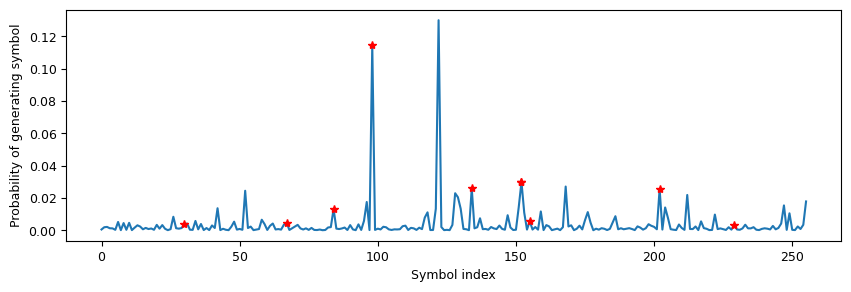

In [23]:
with torch.no_grad():

    # step.1 compute the probablity vector
    # get the logits
    logits = m_output.l_trans(input_feat)

    # for visualization, let's sharpen the distribution
    #.  this is also used in some models.
    #.  let's use a very large value
    logits = logits * 20

    prob_vec = torch_nn_func.softmax(logits, dim=2)


    # step.2 create the distribution
    # wrap around the categorical distribution
    distrib = torch.distributions.Categorical(prob_vec)


# plot the figure for the first signal in the mini-batch
batch_idx = 0


fig = plt.figure(figsize=(10,3))
axis = fig.add_subplot(111)
axis.plot(prob_vec[batch_idx, 0].numpy())
axis.set_xlabel('Symbol index');
axis.set_ylabel('Probability of generating symbol');


# step.3 we can draw multiple samples show the distribution
with torch.no_grad():
    # let's
    for _ in range(10):
        sample = distrib.sample()
        sample = np.array(sample.numpy(), dtype=np.int32)
        axis.plot(sample[batch_idx],
                  prob_vec[batch_idx, 0, sample[batch_idx]].numpy(),
                  color='r', marker='*')

# We can see that the sample generated (red star) is around from the
# bin that has a high probability

## Sec.1.6 Full Definition of WaveNet

We will put all the modules together

This version of WaveNet is also defined in `/content/sandbix/block_wavenet.py WaveNet_v1`.

Note that we not only have a `forward` method used in model training but also an `inference` method used for waveform generation. We will explain this later.

In [24]:
class WaveNet_v1(torch_nn.Module):
    """ Model definition of WaveNet
    Example definition of WaveNet, version 1

    """
    def __init__(self, in_dim, up_sample_rate, num_bits = 10, wnblock_ver=1,
                 pre_emphasis=True):
        """ WaveNet(in_dim, up_sample_rate, num_bits=10, wnblock_ver=1,
        pre_emphasis=False)

        Args
        ----
          in_dim: int, dimension of condition feature (batch, length, in_dim)
          up_sample_rate, int, condition feature will be up-sampled by
                   using this rate
          num_bits: int, number of bits for mu-law companding, default 10
          wnblock_ver: int, version of the WaveNet Block, default 1
                       wnblock_ver = 1 uses WaveNetBlock
                       wnblock_ver = 2 uses WaveNetBlock_v2
          pre_emphasis: bool, whether use pre-emphasis on the target waveform

        up_sample_rate can be calculated using frame_shift of condition feature
        and waveform sampling rate. For example, 16kHz waveform, condition
        feature (e.g., Mel-spectrogram) extracted using 5ms frame shift, then
        up_sample_rate = 16000 * 0.005 = 80. In other words, every frame will
        be replicated 80 times.
        """
        super(WaveNet_v1, self).__init__()

        #################
        ## model config
        #################
        # number of bits for mu-law
        self.num_bits = num_bits
        self.num_classes = 2 ** self.num_bits

        # up-sample rate
        self.up_sample = up_sample_rate

        # wavenet blocks
        #  residual channel dim
        self.res_ch_dim = 64
        #  gated activate dim
        self.gate_act_dim = 64
        #  condition feature dim
        self.cond_dim = 64
        #  skip channel dim
        self.skip_ch_dim = 256
        #  dilation size
        self.dilations = [2 ** (x % 10) for x in range(30)]

        # input dimension of (conditional feature)
        self.input_dim = in_dim

        # version of wavenet block
        self.wnblock_ver = wnblock_ver

        # whether pre-emphasis
        self.pre_emphasis = pre_emphasis
        ###############
        ## network definition
        ###############
        # condition module
        self.l_cond = CondModule(self.input_dim, self.cond_dim, self.up_sample)

        # waveform embedding layer
        self.l_wav_emb = torch_nn.Embedding(self.num_classes, self.res_ch_dim)

        # dilated convolution layers
        tmp_wav_blocks = []
        for dilation in self.dilations:
            if self.wnblock_ver == 2:
                tmp_wav_blocks.append(
                    WaveNetBlock_v2(
                        self.res_ch_dim, self.skip_ch_dim, self.gate_act_dim,
                        self.cond_dim, dilation))
            else:
                tmp_wav_blocks.append(
                    WaveNetBlock(
                        self.res_ch_dim, self.skip_ch_dim, self.gate_act_dim,
                        self.cond_dim, dilation))
        self.l_wavenet_blocks = torch_nn.ModuleList(tmp_wav_blocks)

        # output block
        self.l_output = OutputBlock(self.skip_ch_dim, self.num_classes)

        # done
        return

    def _waveform_encode_target(self, target_wav):
        return nii_dsp.mulaw_encode(target_wav, self.num_classes)

    def _waveform_decode_target(self, gen_wav):
        return nii_dsp.mulaw_decode(gen_wav, self.num_classes)

    def forward(self, input_feat, wav):
        """loss = forward(self, input_feat, wav)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)
          wav: tensor, target waveform (batchsize, length2, 1)
               it should be raw waveform, flot valued, between (-1, 1)
               it will be companded using mu-law automatically
        output
        ------
          loss: tensor / scalar

        Note: returned loss can be directly used as the loss value
        no need to write Loss()
        """

        # step1. prepare the target waveform and feedback waveform
        #  do mu-law companding
        #  shifting by 1 time step for feedback waveform
        with torch.no_grad():
            if self.pre_emphasis:
                wav[:, 1:, :] = wav[:, 1:, :] - 0.97 * wav[:, 0:-1, :]

            # mu-law companding (int values)
            # note that _waveform_encoder_target will produce int values
            target_wav = self._waveform_encode_target(wav)

            # feedback wav
            fb_wav = torch.zeros(
                target_wav.shape, device=wav.device, dtype=target_wav.dtype)
            fb_wav[:, 1:] = target_wav[:, :-1]

        # step2. condition feature
        hid_cond = self.l_cond(input_feat)

        # step3. feedback waveform embedding
        hid_wav_emb = self.l_wav_emb(fb_wav.squeeze(-1))

        # step4. stacks of wavenet
        #  buffer to save skip-channel features
        skip_ch_feat = torch.zeros(
            [target_wav.shape[0],target_wav.shape[1], self.skip_ch_dim],
            device=input_feat.device, dtype=input_feat.dtype)

        res_ch_feat = hid_wav_emb
        for l_wavblock in self.l_wavenet_blocks:
            res_ch_feat, tmp_skip_ch_feat = l_wavblock(res_ch_feat, hid_cond)
            skip_ch_feat += tmp_skip_ch_feat

        # step5. get output
        likelihood = self.l_output(skip_ch_feat, target_wav)

        return likelihood

    def inference(self, input_feat):
        """wav = inference(mels)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)

        output
        ------
          wav: tensor, target waveform (batchsize, length2, 1)

        Note: length2 will be = length1 * self.up_sample
        """

        # prepare
        batchsize = input_feat.shape[0]
        wavlength = input_feat.shape[1] * self.up_sample

        time_idx_marker = wavlength // 10
        #
        # step1. condition features
        hid_cond = self.l_cond(input_feat)

        # step2. do computation step-by-step
        # initialzie the buffer
        gen_wav_buf = torch.zeros(
            [batchsize, wavlength, 1],
            dtype=input_feat.dtype, device=input_feat.device)

        fb_wav_buf = torch.zeros(
            [batchsize, 1, 1],
            dtype=input_feat.dtype, device=input_feat.device)

        skip_ch_feat = torch.zeros(
            [batchsize, 1, self.skip_ch_dim],
            dtype=input_feat.dtype, device=input_feat.device)

        # loop over all time steps
        print("Total time steps: {:d}. Progress: ".format(wavlength),
              end=' ', flush=True)
        for time_idx in range(wavlength):
            # show messages
            if time_idx % 500 == 1:
                print(time_idx, end=' ', flush=True)

            # feedback
            if time_idx > 0:
                fb_wav_buf = gen_wav_buf[:, time_idx-1:time_idx, :]

            # initialize skip
            skip_ch_feat *= 0

            # embedding
            hid_wav_emb = self.l_wav_emb(fb_wav_buf.squeeze(-1).to(torch.int64))

            # condition feature for current time step
            #  for other time steps, intermediate feat is saved by wave blocks
            hid_cond_tmp = hid_cond[:, time_idx:time_idx+1, :]

            # loop over wavblocks
            res_ch_feat = hid_wav_emb
            for l_wavblock in self.l_wavenet_blocks:
                res_ch_feat, tmp_skip_ch_feat = l_wavblock.inference(
                    res_ch_feat, hid_cond_tmp, time_idx)
                skip_ch_feat += tmp_skip_ch_feat

            # draw sample
            drawn_sample = self.l_output.inference(skip_ch_feat)
            gen_wav_buf[:, time_idx:time_idx+1, :] = drawn_sample


        # decode mu-law
        wave = self._waveform_decode_target(gen_wav_buf)

        # de-emphasis if necessary
        if self.pre_emphasis:
            for idx in range(wave.shape[1] - 1):
                wave[:, idx+1, :] = wave[:, idx+1, :] + 0.97 * wave[:, idx, :]
        return wave


# Sec.2. Using Pre-trained model for waveform generation

Here we load a pre-trained Wavenet_v1 model and generate a sample.


## Sec.2.1 Meta-Model wrapper

For my own implementation, I added another wrapper around the `WaveNet_v1` in order to save the model configuration, load input mean, std, and so on.

In [25]:
# A template meta model wrapper
#
#.  WaveNet_v1 is included as self.m_wavenet
#
class Model(torch_nn.Module):
    """ Model definition
    """
    def __init__(self, in_dim, out_dim, args, prj_conf, mean_std=None):
        super(Model, self).__init__()

        #################
        ## must-have
        #################
        # mean std of input and output
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim,\
                                                         args, mean_std)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)
        self.input_dim = in_dim
        self.output_dim = out_dim

        # a flag for debugging (by default False)
        self.model_debug = False

        #################
        ## model config
        #################
        # number of bits for mu-law
        self.num_bits = 10

        # Up-sampling rate is 80 for this model
        #  in my Pytorch script, this should be loaded from prj_conf
        #self.up_sample = prj_conf.input_reso[0]
        self.up_sample = 80

        # model
        # Most of the configurations are fixed in sandbox.block_wavenet.py
        self.m_wavenet = WaveNet_v1(in_dim, self.up_sample, self.num_bits)

        # done
        return

    def prepare_mean_std(self, in_dim, out_dim, args, data_mean_std=None):
        """
        """
        if data_mean_std is not None:
            in_m = torch.from_numpy(data_mean_std[0])
            in_s = torch.from_numpy(data_mean_std[1])
            out_m = torch.from_numpy(data_mean_std[2])
            out_s = torch.from_numpy(data_mean_std[3])
            if in_m.shape[0] != in_dim or in_s.shape[0] != in_dim:
                print("Input dim: {:d}".format(in_dim))
                print("Mean dim: {:d}".format(in_m.shape[0]))
                print("Std dim: {:d}".format(in_s.shape[0]))
                print("Input dimension incompatible")
                sys.exit(1)
            if out_m.shape[0] != out_dim or out_s.shape[0] != out_dim:
                print("Output dim: {:d}".format(out_dim))
                print("Mean dim: {:d}".format(out_m.shape[0]))
                print("Std dim: {:d}".format(out_s.shape[0]))
                print("Output dimension incompatible")
                sys.exit(1)
        else:
            in_m = torch.zeros([in_dim])
            in_s = torch.ones([in_dim])
            out_m = torch.zeros([out_dim])
            out_s = torch.ones([out_dim])

        return in_m, in_s, out_m, out_s

    def normalize_input(self, x):
        """ normalizing the input data
        """
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        """ normalizing the target data
        """
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        """ denormalizing the generated output from network
        """
        return y * self.output_std + self.output_mean

    def _waveform_encode_target(self, target_wav):
        return nii_dsp.mulaw_encode(target_wav, self.num_classes)

    def _waveform_decode_target(self, gen_wav):
        return nii_dsp.mulaw_decode(gen_wav, self.num_classes)

    def forward(self, input_feat, wav):
        """loss = forward(self, input_feat, wav)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)
          wav: tensor, target waveform (batchsize, length2, 1)
               it should be raw waveform, flot valued, between (-1, 1)
               the code will do mu-law conversion
        output
        ------
          loss: tensor / scalar

        Note: returned loss can be directly used as the loss value
        no need to write Loss()
        """
        # normalize input features
        input_feat = self.normalize_input(input_feat)
        # compute cross-entropy using wavenet
        return self.m_wavenet.forward(input_feat, wav)

    def inference(self, input_feat):
        """wav = inference(mels)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)

        output
        ------
          wav: tensor, target waveform (batchsize, length2, 1)

        Note: length2 will be = length1 * self.up_sample
        """
        # normalize the input
        input_feat = self.normalize_input(input_feat)
        # get the output waveform
        wave = self.m_wavenet.inference(input_feat)
        return wave

## Sec.2.2 Load Pre-trained Model

In [26]:
# input feature dim (80 dimension Mel-spec)
mel_dim = 80
input_dim = mel_dim

# output dimension = 1 for waveform
output_dim = 1
# sampling rate of waveform (Hz)
sampling_rate = 16000

# declare the model
m_wavenet = Model(input_dim, output_dim, None, None)

In [27]:
# load pre-trained model
device=torch.device("cpu")
m_wavenet.to(device, dtype=torch.float32)


pretrained_file = os.path.join(g_workpath, "data_models/pre_trained_wavenet/__pre_trained/trained_network.pt")

if os.path.isfile(pretrained_file):
    checkpoint = torch.load(pretrained_file, map_location="cpu")
    m_wavenet.load_state_dict(checkpoint)
else:
    print("Cannot find pre-trained model {:s}".format(pretrained_file))
    print("Please run 00_download_model.sh and download the pre-trained model")

## Sec.2.3 Generate waveform

We will do copy-synthesis:
1. Extract acoustic features from a waveform
2. Generate a waveform


In [28]:
# Step.1

import sys
import os
import data_models.scripts.sub_get_mel as nii_mel_tk

# configuration
sampling_rate = 16000
fftl_n = 1024
frame_length = 400
# This must be compatible with the WaveNet up-sampling rate configuration
frame_shift = 80
frame_length_in_ms = int(frame_length*1000/sampling_rate)
frame_shift_in_ms = int(frame_shift*1000/sampling_rate)


# Use waveform from this folder
input_waveform_path = os.path.join(g_workpath, "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav")
input_mel = nii_mel_tk.get_melsp(input_waveform_path, fftl=fftl_n, fl=frame_length, fs=frame_shift)

# If you have problem running the code above, please just load the pre-extracted features
# mel_dim = 80
#input_mel = tool_lib.read_raw_mat(os.path.join(g_workpath, "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.mfbsp", mel_dim))

# Trim the mel and generate only a short segment of waveform
# You may trim it further
input_mel = input_mel[:290, :]

In [29]:
print("Input Mel shape:" + str(input_mel.shape))
# compose the input tensor
input_tensor = torch.tensor(input_mel, dtype=torch.float32).unsqueeze(0)
print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(290, 80)
Input data tensor shape:torch.Size([1, 290, 80])


In [30]:
# step2. generate waveform
#
# This autoregressive generation process is slow.
# Please be patient!
with torch.no_grad():
    output_waveform = m_wavenet.inference(input_tensor)

Total time steps: 23200. Progress:  1 501 1001 1501 2001 2501 3001 3501 4001 4501 5001 5501 6001 6501 7001 7501 8001 8501 9001 9501 10001 10501 11001 11501 12001 12501 13001 13501 14001 14501 15001 15501 16001 16501 17001 17501 18001 18501 19001 19501 20001 20501 21001 21501 22001 22501 23001 

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Frame index', ylabel='Frequency bins'>)

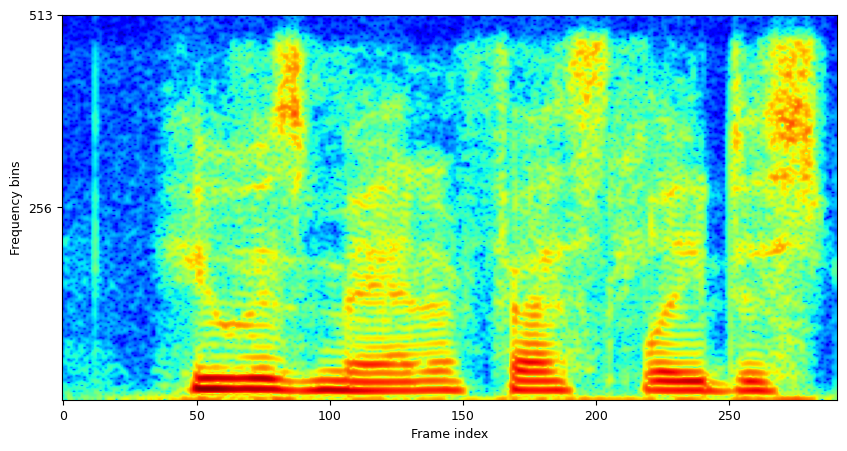

In [31]:
IPython.display.display(
    IPython.display.Audio(output_waveform[0, :, 0].numpy(), rate=sampling_rate))

# plot the spectrogram of the generated waveform
plot_API.plot_API(output_waveform[0,:,0].numpy(), plot_lib.plot_spec, 'single')

You can try to generate the full utterance by commenting out this line when preparing the input Mel-spectrogram

```sh
# trim the mel for quick demonstration
input_mel = input_mel[:290, :]
```


# Sec.3. Note on Autoregressive Generation

> This is based on a very old slide. Page 50 - 56 of slide `CURRENNT WaveNet` on [this webpage](http://tonywangx.github.io/slide.html)

Autoregressive generation is known to be slow since the generation time is in proportion to the waveform length $N$, i.e., $T∝\mathcal{O}(N)$.


There was a pioneering paper called FastWaveNet https://arxiv.org/abs/1611.09482 on this topic, but what FastWaveNet proposes is to avoid the naive Tensorflow implementation that does $T∝\mathcal{O}(N^2)$. The idea is still on how to achieve a "normal-speed" WaveNet $T∝\mathcal{O}(N)$.

WaveNet by design follows $T∝\mathcal{O}(N)$. We can make it faster by using other advanced models (e.g., sub-band WaveNet).

In this section, we only talk about how to do $T∝\mathcal{O}(N)$. This is not that straightforward in implementation.

## Sec.3.1 Explanation

In the above Pytorch module definitions, you may notice that some modules have two working modes:

* **forward()** for training: given input in shape `(batch, length, dimension)`, compute output `(batch, length, dimension)`
* **inference()** for generation: given input in shape `(batch, length=1, dimension)` and past feature if necessary, compute output `(batch, length=1, dimension)`


Some modules don't need to do so. For example, FC can use the exactly same **forward()** for both training and generation. The reason is that they don't rely on input features from previous time steps.


Therefore, here we focus on the Convolution layers.

Let's use $z$, $x$, $y$ to denote the input, hidden, and output signals.

Suppose two causal conv layers with a kernel size 2. Given input $(z_1, z_2, \cdots)$, we first generate $(x_1, x_2, \cdots)$, then we generate the output $(y_1, y_2, \cdots)$


```sh
step1         step2         step3                step4                  step5    
y[1]           y[2]           y[3]                 y[4]                   y[5]          
 |              |           /    |              /     |               /     |          
 |              |          /     |             /      |              /      |      dilation 2
 |              |         /      |            /       |             /       |          
x[1]           x[2]    x[1]    x[3]        x[2]      x[4]         x[3]     x[5]      
 |             /|        |      /|         /|        /|           /|       /|      
 |            / |        |     / |        / |       / |          / |      / |     dilation 1
 |           /  |        |    /  |       /  |      /  |         /  |     /  |      
z[1]      z[1] z[2]    z[1] z[2] z[3]  z[1] z[2] z[3] z[4]   z[2] z[3] z[4] z[5]   
```

How can implement the above computation?

**Method 1: Naive implementation**

no cache, do computation step by step

```sh
for step1, x[1] <- conv(z[1], 0),    
           y[1] <- conv(x[1], 0)

for step2, x[2] <- conv(z[2], z[1]),
           y[2] <- conv(x[2], 0)

for step3, x[1] <- conv(z[1], 0),
           x[3] <- conv(z[3], z[2]),
           y[3] <- conv(x[3], x[1])
           
for step4, x[2] <- conv(z[2], z[1]),
           x[4] <- conv(z[4], z[3]),
           y[4] <- conv(x[4], x[2])
           
...
```

In the above example, we need to do 3 convolution operations per time step.

If we have $L$ conv layers where the kernel size is $k$, the number of conv() operations required for a single time step becomes $\sum_{i=1}^L k^{i-1} = k^L-1$.

(in the above example $k=2$ and $\sum_{i=1}^2 k^{i-1} = 3$)

Thus, the time complexity will be $\mathcal{O}(k^{L}N)$ to generate a waveform of length $N$ from a network with $L$ conv layers.


**Method 2: Memory hungry implementation**

In the naive implementation, notice that x[1] is computed for step 1 and 3, and x[2] is used in step 2 and 4. If we cache the intermediate features in memory, we can avoid some of the computations.

```sh
for step1, x[1] <- conv(z[1], 0)
           y[1] <- conv(x[1], 0)
           save x[1] -> Memory
           
for step2, x[2] <- conv(z[2], z[1])
           y[2] <- conv(x[2], 0)
           save x[2] -> Memory
           
for step3, x[3] <- conv(z[3], z[2])
           get x[1] <- Memory
           y[3] <- conv(x[3], x[1])
           save x[3] -> Memory
           
for step4, x[4] <- conv(z[4], z[3])
           get x[2] <- Memory
           y[4] <- conv(x[4], x[2])
           save x[4]
...
```

For each step, the number of conv() operations is decided by the number of layers $\mathcal{O}(L)$. The total is $\mathcal{O}(LN)$.

However, to cache all the data, we need memory of $\mathcal{O}(LN)$ in size.

**Method 3: Memory efficient implementation**

Cache data but delete what is not needed anymore

```sh
for step1, x[1] <- conv(z[1], 0),    
                   x[1]
                    |   save
                    v
           Cache  [x[1], 0, 0]
           y[1] <- conv(x[1], 0)
           
for step2, x[2] <- conv(z[2], z[1])
                         x[1]
                          |   save
                          v
           Cache [x[1], x[2], 0]
           y[2] <- conv(x[2], 0, 0)
           
for step3, x[3] <- conv(z[3], z[2]),
                               x[3]
                                |   save
                                v
           Cache  [x[1], x[2], x[3]]
            y[3] <- conv(x[3], x[1])
           
for step4, x[4] <- conv(z[4], z[3]),
                   x[4]
                    |   save and overwrite
                    v
           Cache [x[4], x[2], x[3]]
           y[4] <- conv(x[4], x[2])
...
```

Notice in step4, we delete x[1] from the cache because it will never be used.

The size of the cache depends on the dilation size.

The time complexity to generate a waveform of length $N$ is $\mathcal{O}(LN)$.

To cache the data for the layer, the memory size is $(K-1)I+1$ where $I$ and $K$ are the kernel and dilation sizes, respectively. Thus, The total number of cache is $\mathcal{O}(LKI)$ and $KI$ is usually smaller than waveform length $N$.

(A better figure is on Page 50 - 56 of slide `CURRENNT WaveNet` on [this page](http://tonywangx.github.io/slide.html)))

In implementation, method 3 can be done by moving the pointer to the cache:

```sh
step 0, Cache = [x[1],   0,     0]
        y[1] <- conv(Cache[0], Cache[0-2])
step 1, Cache = [x[1], x[2],    0]
        y[2] <- conv(Cache[1], Cache[1-2])
step 2, Cache = [x[1], x[2], x[3]]
        y[3] <- conv(Cache[2], Cache[2-2])
step 3, Cache = [x[4], x[2], x[3]]
        y[4] <- conv(Cache[0], Cache[0-2])
step 4, Cache = [x[4], x[5], x[3]]
        y[5] <- conv(Cache[1], Cache[1-2])
        
step n, Cache = [...]
        y[n] <- conv(Cache[n%3], Cache[n%3-2])
        
        Data position in cache depends on n
```

In general
```sh

step n, Cache = [...]
        y[n] <- conv(Cache[n % cache_length], Cache[n % cache_length - dilation_length])

```



This is similar to FastWaveNet, but it does not use any queue.

This is the implementation in this notebook.

In short, to generate a waveform of length $N$ using a network with $L$ of kernel size $K$ and dilation size $I$ convolution layers, the complexity is roughly:

Complexity         | Naive Method | Method 2 | Method 3
-------------------|----------|----------|---------
Time               | $\mathcal{O}(K^LN)$  |  $\mathcal{O}(LN)$ | $\mathcal{O}(LN)$
Memory             | $\mathcal{O}(1)$     |  $\mathcal{O}(LN)$ | $\mathcal{O}(LKI)$

## Sec.3.2 Implementation of Conv1D in WaveNet

Conv1d with the above inference() method is wrapped around in `/content/sandbox/block_nn.py`, `Conv1dForARModel`

This is what WaveNetBlock uses.

In implementation, **forward()** has an additional argument **step_idx**:
1. When **step_idx** is provided, the method conducts the step-by-step
2. generation. When **step_idx** is None, the method is for training.


In [32]:
class Conv1dForARModel(nii_nn.Conv1dKeepLength):
    """ Definition of dilated Convolution for autoregressive model

    This module is based on block_nn.py/Conv1DKeepLength.
    However, Conv1DKeepLength doesn't assume step-by-step generation
    for autogressive model.

    This Module further adds the method to generate output in AR model
    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s,
                 bias=True, tanh = True, causal=True):
        """ Conv1dForARModel(input_dim, output_dim, dilation_s, kernel_s,
            bias=True, tanh=True)

        args
        ----
          input_dim: int, input tensor should be (batchsize, length, input_dim)
          output_dim: int, output tensor will be (batchsize, length, output_dim)
          dilation_s: int, dilation size
          kernel_s: int, kernel size
          bias: bool, whether use bias term, default True
          tanh: bool, whether apply tanh on the output, default True
          causal: bool, whether the convoltuion is causal, default True

        Note that causal==False, step-by-step AR generation will raise Error
        """
        super(Conv1dForARModel, self).__init__(
            input_dim, output_dim, dilation_s, kernel_s, \
            causal = causal, stride = 1, groups=1, bias=bias, tanh = tanh)

        # configuration options
        self.use_bias = bias
        self.use_tanh = tanh
        self.kernel_s = kernel_s
        self.dilation_s = dilation_s
        self.out_dim = output_dim
        self.causal = causal

        # See slide http://tonywangx.github.io/slide.html#misc CURRENNT WaveNet,
        # page 50-56 for example on kernel_s = 2
        #
        # buffer length, depends on kernel size and dilation size
        # kernel_size = 3, dilation_size = 1 -> * * * -> buffer_len = 3
        # kernel_size = 3, dilation_size = 2 -> * . * . * -> buffer_len = 5
        self.buffer_len = (kernel_s - 1) * dilation_s + 1
        self.buffer_data = None
        # self.buffer_conv1d = None
        return

    def forward(self, x, step_idx = None):
        """ output = forward(x, step_idx)

        input
        -----
          x: tensor, in shape (batchsize, length, input_dim)
          step_idx: int, the index of the current time step
                    or None
        output
        ------
          output: tensor, in shape (batchsize, length, output_dim)

        If step_idx is True
        ------------------------
          this is same as common conv1d forward method

        If self.training is False
        ------------------------
          This method assumes input and output tensors
          are for one time step, i.e., length = 1 for both x and output.
          This method should be used in a loop, for example:

          model.eval()
          for idx in range(total_time_steps):
              ...
              output[:, idx:idx+1, :] = forward(x[:, idx:idx+1, :])
              ...
        """
        if step_idx is None:
            # normal training mode, use the common conv forward method
            return super(Conv1dForARModel, self).forward(x)
        else:
            if self.causal is False:
                print("Step-by-step generation cannot work on non-causal conv")
                print("Please use causal=True for Conv1dForARModel")
                sys.exit(1)
            # step-by-step for generation in AR model

            # initialize buffer if necessary
            if step_idx == 0:
                self.buffer_data = torch.zeros(
                    [x.shape[0], self.buffer_len, x.shape[-1]],
                    dtype=x.dtype, device=x.device)
                #self.buffer_conv1d = torch.zeros(
                #    [x.shape[0], self.kernel_s, x.shape[-1]],
                #    dtype=x.dtype, device=x.device)

            # Put new input data into buffer
            #  the position index to put the input data
            #
            # Cache[n % cache_len] <- x[n]
            #
            tmp_ptr_save = step_idx % self.buffer_len
            #  assume x is (batchsize, length=1, input_dim), thus
            #  only take x[:, 0, :]
            self.buffer_data[:, tmp_ptr_save, :] = x[:, 0, :]

            #  initialize
            output_tensor = torch.zeros(
                [x.shape[0], self.out_dim], dtype=x.dtype, device=x.device)

            #  loop over the kernel
            #
            #  y[n] <- conv(Cache[n % cache_len], Cache[(n - dila)% cache_len ], ...)
            #
            #
            for ker_idx in range(self.kernel_s):
                # (n - ker_idx * I)% cache_len
                tmp_data_idx = (step_idx - ker_idx * self.dilation_s) \
                               % self.buffer_len
                # apply the kernel and sum the product
                # note that self.weight[:, :, -1] is the 1st kernel
                output_tensor += torch.matmul(
                    self.buffer_data[:, tmp_data_idx, :],
                    self.weight[:, :, self.kernel_s - ker_idx - 1].T)


            # apply bias and tanh if necessary
            if self.use_bias:
                output_tensor += self.bias
            if self.use_tanh:
                output_tensor = torch.tanh(output_tensor)

            # make it to (batch, length=1, output_dim)
            return output_tensor.unsqueeze(1)



Example usage:


In [33]:
batchsize = 1
input_dim = 1
output_dim = 1
dilation = 2
kernel_s = 3

# Build a layer
l_conv1 = Conv1dForARModel(input_dim, output_dim, dilation, kernel_s, tanh=False, bias=True)

# Create a data sequence
length = 50
input = torch.rand([batchsize, length, input_dim])

# Mode 1, all time steps at the same time
with torch.no_grad():
    output_all = l_conv1(input)

# Mode 2, step-by-step generation
with torch.no_grad():
    out_step_by_step = torch.zeros([batchsize, length, output_dim])
    # step is the time index we need to provide to the convolution layer
    for step in range(length):
        out_step_by_step[:, step:step+1, :] = l_conv1(input[:, step:step+1, :], step)



That's all

# License
```
BSD 3-Clause License

Copyright (c) 2022, Xin Wang, National Institute of Informatics
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

The used audio sample is from [CMU Arctic database](http://www.festvox.org/cmu_arctic/):

```
Kominek, John, and Alan W. Black. "The CMU Arctic speech databases." Fifth ISCA workshop on speech synthesis. 2004.
```

```
This voice is free for use for any purpose (commercial or otherwise)
subject to the pretty light restrictions detailed below.

############################################################################
###                                                                       ##
###                     Carnegie Mellon University                        ##
###                         Copyright (c) 2003                            ##
###                        All Rights Reserved.                           ##
###                                                                       ##
###  Permission to use, copy, modify,  and licence this software and its  ##
###  documentation for any purpose, is hereby granted without fee,        ##
###  subject to the following conditions:                                 ##
###   1. The code must retain the above copyright notice, this list of    ##
###      conditions and the following disclaimer.                         ##
###   2. Any modifications must be clearly marked as such.                ##
###   3. Original authors' names are not deleted.                         ##
###                                                                       ##
###  THE AUTHORS OF THIS WORK DISCLAIM ALL WARRANTIES WITH REGARD TO      ##
###  THIS SOFTWARE, INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY   ##
###  AND FITNESS, IN NO EVENT SHALL THE AUTHORS BE LIABLE FOR ANY         ##
###  SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES            ##
###  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN   ##
###  AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION,          ##
###  ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF       ##
###  THIS SOFTWARE.                                                       ##
###                                                                       ##
############################################################################
###                                                                       ##
###  See http://www.festvox.org/cmu_arctic/ for more details              ##
###                                                                       ##
############################################################################

```

# ACKNOWLEDGEMENT

We thank CMU for providing the CMU Arctic database.

This work is partially supported by JST CREST Grants (JPMJCR18A6 and JPMJCR20D3), MEXT KAKENHI Grants (21K17775, 21H04906).